# Computing Heterogenous Agent Jacobians in HARK

By William Du

This notebook illustrates how to compute Heterogenous Agent Jacobian matrices in HARK.

These matrices are a fundamental building building block to solving Heterogenous Agent New Keynesian Models with the sequence space jacobian methodology. For more information, see [Auclert, Rognlie, Bardoszy, and Straub (2021)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434)

For the IndShockConsumerType, Jacobians of Consumption and Saving can be computed with respect to the following parameters:
LivPrb, PermShkStd,TranShkStd,UnempPrb, Rfree, IncUnemp.

In [1]:
import time

import matplotlib.pyplot as plt

from HARK.ConsumptionSaving.ConsNewKeynesianModel import (
    NewKeynesianConsumerType,
)

## Create Agent

In [2]:
# Dictionary for Agent
Dict = {
    # Solving Parameters
    "aXtraMax": 1000,
    "aXtraCount": 200,
    # Transition Matrix Simulations Parameters
    "mMax": 10000,
    "mMin": 1e-6,
    "mCount": 300,
    "mFac": 3,
}

In [3]:
Agent = NewKeynesianConsumerType(**Dict)

## Compute Steady State

In [4]:
start = time.time()
Agent.compute_steady_state()
print("Seconds to compute steady state", time.time() - start)

Seconds to compute steady state 9.832530975341797


## Compute Jacobians

Shocks possible: LivPrb, PermShkStd,TranShkStd, DiscFac,UnempPrb, Rfree, IncUnemp

### Shock to Standard Deviation to Permanent Income Shocks

In [5]:
start = time.time()

CJAC_Perm, AJAC_Perm = Agent.calc_jacobian("PermShkStd", 300)

print("Seconds to calculate Jacobian", time.time() - start)

Seconds to calculate Jacobian 2.5753915309906006


#### Consumption Jacobians

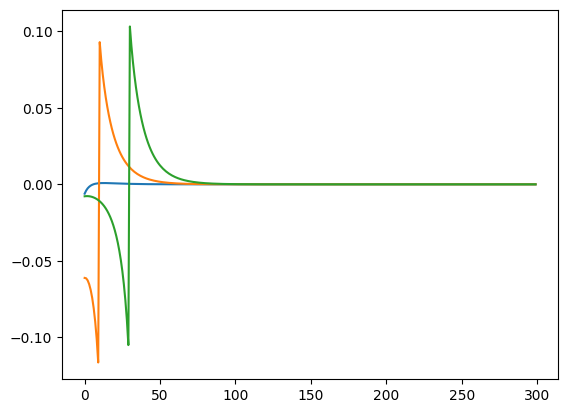

In [6]:
plt.plot(CJAC_Perm.T[0])
plt.plot(CJAC_Perm.T[10])
plt.plot(CJAC_Perm.T[30])
plt.show()

#### Asset Jacobians

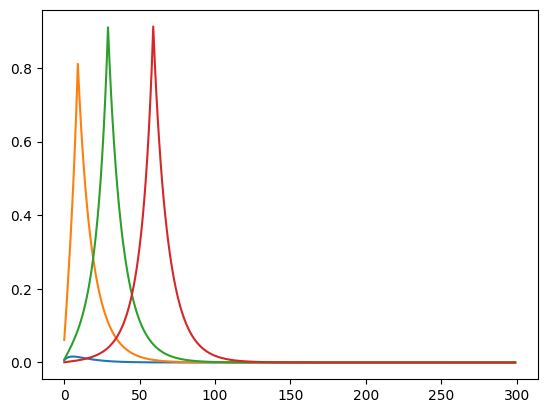

In [7]:
plt.plot(AJAC_Perm.T[0])
plt.plot(AJAC_Perm.T[10])
plt.plot(AJAC_Perm.T[30])
plt.plot(AJAC_Perm.T[60])
plt.show()

## Shock to Real Interest Rate

In [8]:
CJAC_Rfree, AJAC_Rfree = Agent.calc_jacobian("Rfree", 300)

#### Consumption Jacobians

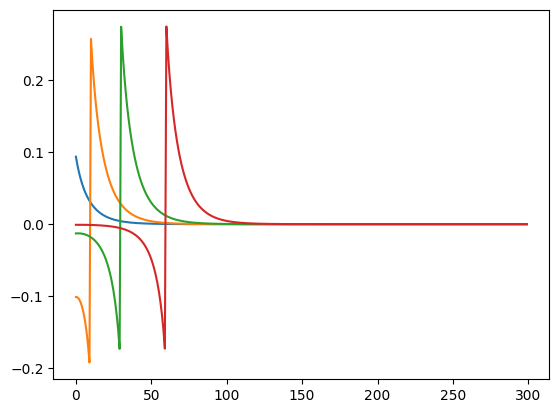

In [9]:
plt.plot(CJAC_Rfree.T[0])
plt.plot(CJAC_Rfree.T[10])
plt.plot(CJAC_Rfree.T[30])
plt.plot(CJAC_Rfree.T[60])
plt.show()

#### Asset Jacobians

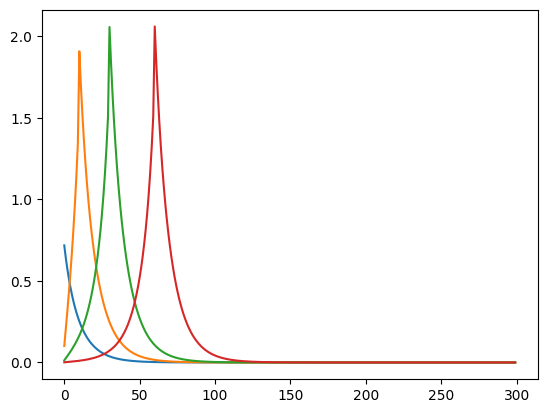

In [10]:
plt.plot(AJAC_Rfree.T[0])
plt.plot(AJAC_Rfree.T[10])
plt.plot(AJAC_Rfree.T[30])
plt.plot(AJAC_Rfree.T[60])
plt.show()

## Shock to Unemployment Probability

In [11]:
CJAC_UnempPrb, AJAC_UnempPrb = Agent.calc_jacobian("UnempPrb", 300)

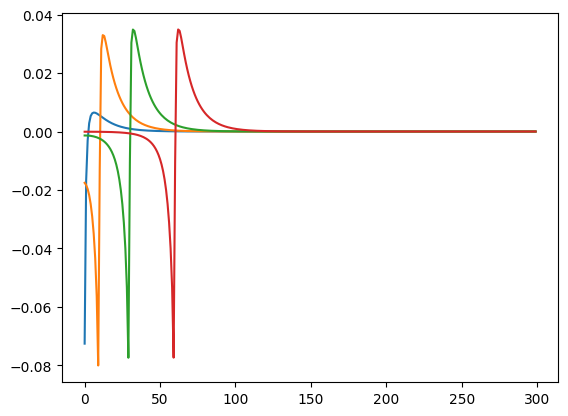

In [12]:
plt.plot(CJAC_UnempPrb.T[0])
plt.plot(CJAC_UnempPrb.T[10])
plt.plot(CJAC_UnempPrb.T[30])
plt.plot(CJAC_UnempPrb.T[60])
plt.show()

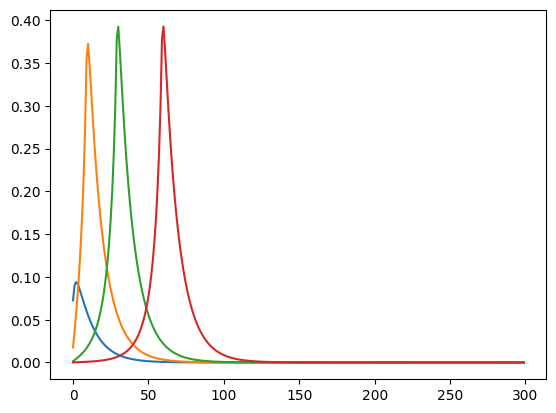

In [13]:
plt.plot(AJAC_UnempPrb.T[0])
plt.plot(AJAC_UnempPrb.T[10])
plt.plot(AJAC_UnempPrb.T[30])
plt.plot(AJAC_UnempPrb.T[60])
plt.show()